In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import Steerable.nn as snn

# Figure 2

### Spherical grid misalignment under right angle rotation

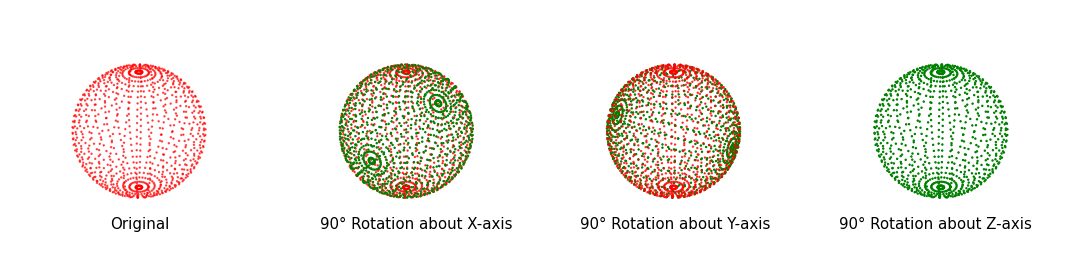

In [18]:
def spherical_grid_3d(n_angle):
    j = torch.arange(n_angle)
    theta, phi = torch.meshgrid(torch.pi * (j + 0.5) / n_angle, 2*torch.pi*(j+0.5) / n_angle, indexing='ij')
    x = (torch.sin(theta) * torch.cos(phi)).flatten()
    y = (torch.sin(theta) * torch.sin(phi)).flatten()
    z = torch.cos(theta).flatten()
    return torch.vstack([x, y, z])

def rotate_points(points, axis='x', angle_deg=90):
    angle_rad = np.radians(angle_deg)
    if axis == 'x':
        R = torch.tensor([[1, 0, 0],
                      [0, np.cos(angle_rad), -np.sin(angle_rad)],
                      [0, np.sin(angle_rad),  np.cos(angle_rad)]])
    elif axis == 'y':
        R = torch.tensor([[ np.cos(angle_rad), 0, np.sin(angle_rad)],
                      [0, 1, 0],
                      [-np.sin(angle_rad), 0, np.cos(angle_rad)]])
    elif axis == 'z':
        R = torch.tensor([[np.cos(angle_rad), -np.sin(angle_rad), 0],
                      [np.sin(angle_rad),  np.cos(angle_rad), 0],
                      [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    return R.type(torch.float) @ points

def plot_rotated_vs_original(n_angle):
    points = spherical_grid_3d(n_angle)
    fig, axes = plt.subplots(nrows=1, ncols=4, subplot_kw={"projection": "3d"}, gridspec_kw={'hspace':0})
    fig.set_size_inches(15,4)
    
    for ax in axes:
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_zlim([-1.1, 1.1])
        ax.set_box_aspect([1, 1, 1])
        ax.axis('off')

    # Plot original grid
    axes[0].scatter(points[0], points[1], points[2],
                color='red', s=2, alpha=0.6, label='Original')
    fig.text(0.105,0.175,s=f'Original', fontsize=15)

    for i, rotation_axis in enumerate(['x', 'y', 'z']):
        rotated = rotate_points(points, axis=rotation_axis, angle_deg=90)
        if rotation_axis in ['x', 'y']:
            # Plot original grid
            axes[i+1].scatter(points[0], points[1], points[2],
                    color='red', s=2, alpha=0.7, label='Original')

        # Plot rotated grid
        axes[i+1].scatter(rotated[0], rotated[1], rotated[2],
                   color='green', s=2, alpha=1.0, label=f'Rotated about {rotation_axis.upper()}')

        fig.text(0.24*i + 0.3,0.175,s=f'90° Rotation about {rotation_axis.upper()}-axis', fontsize=15)
        
    plt.tight_layout()
    plt.show()

# Main
plot_rotated_vs_original(32)

# Figure 3

### Error control by using finer grid

In [175]:
class GaussianDataset(torch.utils.data.Dataset):
    def __init__(self, size, mean=0.0, std=1.0, length=1000):
        self.mean = mean
        self.std = std
        self.size = size
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx >= self.length:
            raise ValueError(f'Index{idx} out of range for dataset of length {self.length}')
        image = torch.randn(self.size) * self.std + self.mean
        label = 0
        return image, label
    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
degrees = torch.arange(0, 361, 10)
n_sim = 50

def check_equivariance(models, dataset, transfomation=None):
    values = torch.zeros(n_sim, len(models), len(degrees))
    for sim in range(n_sim):
        inputs = dataset[torch.randint(0, len(dataset), (1,)).item()][0]
        norm = torch.abs(inputs).mean()
        for i, model in enumerate(models):
            with torch.no_grad():
                for parameters in model.parameters():
                    parameters.copy_(torch.randn_like(parameters))
                for j, degree in enumerate(degrees):
                    with torch.no_grad():
                        outputs1 = model(inputs.unsqueeze(0).to(device))[0].cpu()
                        outputs2 = model(transfomation(inputs, degree).unsqueeze(0).to(device))[0].cpu()
                        values[sim, i, j] = 100 * (outputs1-outputs2).max().abs() / norm

        print(f'Simulation : {sim+1} / {n_sim}', end='\r')
    return torch.stack([values.mean(dim=0), values.std(dim=0)], dim=-1)
    

## 2D

In [ ]:
# Model
class Model(torch.nn.Module):
    def __init__(self, n_angle, interpolation_type):
        super().__init__()
        freq_cutoff = 4

        self.network = torch.nn.Sequential(
            snn.SE2ConvType1(1, 4, 5, freq_cutoff, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE2ConvType2(4, 16, 5, freq_cutoff, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE2NormFlatten()
        )
        
    def forward(self,x):
        return self.network(x.type(torch.cfloat))
    
dataset = GaussianDataset(size =(1,28,28))
# Interpolation 0
stats0 = check_equivariance([
    Model(n_angle=8, interpolation_type=0).to(device),
    Model(n_angle=32, interpolation_type=0).to(device),
    Model(n_angle=128, interpolation_type=0).to(device),
    ], 
    dataset, lambda x, degree:snn.rotate_image(x, degree, order=1))

# Interpolation 1
stats1 = check_equivariance([
    Model(n_angle=8, interpolation_type=1).to(device),
    Model(n_angle=64, interpolation_type=1).to(device),
    Model(n_angle=512, interpolation_type=1).to(device),
    ], 
    dataset, lambda x, degree:snn.rotate_image(x, degree, order=1))

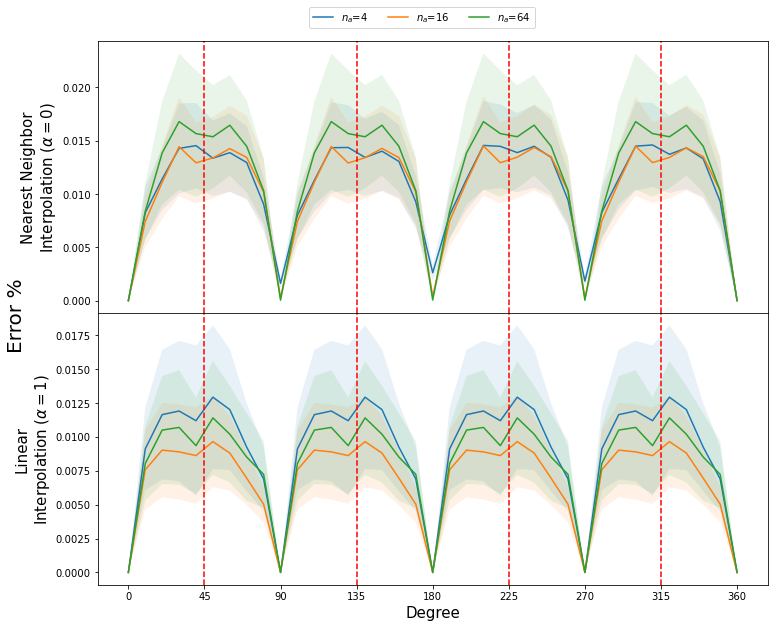

In [177]:
stats = [stats0, stats1]

fig, axes = plt.subplots(nrows=2, ncols=1, gridspec_kw={'hspace':0}, sharex=True)
fig.set_size_inches(12,10)
for interp, stat in enumerate(stats):
    for i in range(len(stat)):
        axes[interp].plot(degrees, stat[i,:,0], label='$n_a$='+f'{4**(i+1)}')
        axes[interp].fill_between(degrees, stat[i,:,0]-1.96*stat[i,:,1]/sqrt(n_sim),  stat[i,:,0]+1.96*stat[i,:,1]/sqrt(n_sim), alpha=0.1)
    #axes[interp].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    axes[interp].set_xticks([45*i for i in range(degrees.max().item()//45 + 1)])
    
    for intercept in [90*i+45 for i in range(round(degrees.max().item()/90))]:
        axes[interp].axvline(intercept, linestyle='dashed', color='red')

axes[0].set_ylabel('Nearest Neighbor\n'r'Interpolation ($\alpha=0$)', size=15)
axes[1].set_ylabel('Linear\n'r'Interpolation ($\alpha=1$)', size=15)
axes[1].set_xlabel('Degree', size=15)
fig.supylabel('Error %', size=20)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.935), ncol=3)
plt.show()

## 3D

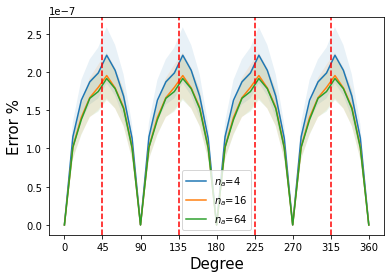

In [60]:
# Model
class Model(torch.nn.Module):
    def __init__(self, n_angle, interpolation_type) -> None:
        super().__init__()

        self.network = torch.nn.Sequential(
            snn.SE3Conv(1, [4,4], 5, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE3Conv([4,4], [16,16], 5, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE3NormFlatten()
        )

    def forward(self,x):
        return self.network(x.type(torch.cfloat))
    
dataset = GaussianDataset(size =(1,32,32,32))
interpolation_type = 0
check_equivariance([Model(n_angle=4, interpolation_type=interpolation_type).to(device),
                    Model(n_angle=16, interpolation_type=interpolation_type).to(device),
                    Model(n_angle=64, interpolation_type=interpolation_type).to(device),
                   ], 
                   dataset, lambda x, degree:snn.rotate_image(x, (degree, 0, 0), order=1))

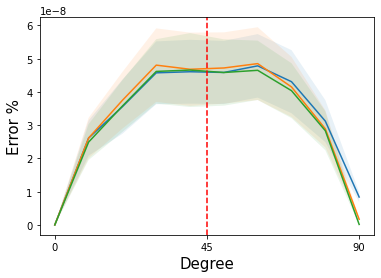

In [47]:
check_equivariance([Model(n_angle=4, interpolation_type=interpolation_type).to(device),
                    Model(n_angle=16, interpolation_type=interpolation_type).to(device),
                    Model(n_angle=64, interpolation_type=interpolation_type).to(device),
                   ], 
                   dataset, lambda x, degree:snn.rotate_image(x, (0, degree, 0), order=1))